# Kinetics Fitting of PpiB

In [43]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sympy import Eq
from symfit import Variable, Parameter, D, Fit, ODEModel, exp
from symfit.core.minimizers import *
from symfit.core.objectives import LeastSquares
from smitting.fitting import ODEFit
import os

In [44]:
directory = '.'

In [45]:
time = np.array([60*60, 30*60, 20*60, 15*60, 10*60, 5*60, 1*60, 40, 20, 0])[::-1]
#time = np.array([10*60, 5*60, 1*60, 40, 20, 0])[::-1]
states = ['FD', 'native', 'i1']

In [46]:
files = [f for f  in os.listdir(directory) if 'curve' in f]
files

['Bwt(2-1)_curve',
 'Bwt(2nd_DS1)_curve',
 'Bwt(AT1)_curve',
 'Bwt(AT1-1)_curve.txt',
 'Bwt(DS1)_curve',
 'Bwt(DS2)_curve',
 'Bwt(LK1)_curve',
 'Bwt(LK2)_curve',
 'Bwt(LK2-1)_curve',
 'Bwt_(DS2-1)_curve',
 'Bwt_2nd(DS1)_curve',
 'Bwt_2nd(DS2)_curve']

In [47]:
# We choose the first file to start with:
data_arr = np.genfromtxt(os.path.join(directory, files[7]))[:, ::-1]
data_arr.shape

(3, 10)

<IPython.core.display.Javascript object>


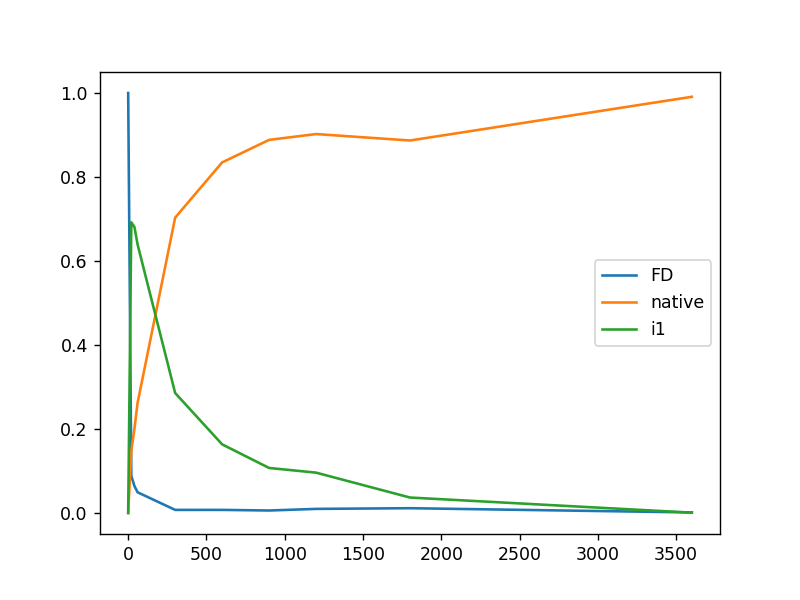

In [48]:
# Plotting the imported data:
plt.figure()
for d, s in zip(data_arr, states):
    plt.plot(time, d, label=s)
_ = plt.legend()

## ODE model fitting

In [49]:
# First we create a dictionary with the names of the states and their data
data = {
    'FD': data_arr[0],
    'Native': data_arr[1], 
    'int1': data_arr[2],
}

# Then another dictionary which defines the inital conditions. 
# At t=0, the concentration of FD is set to one, other to zero
initial = {'t': 0, 'FD': 1, 'int1':0, 'Native': 0}

# We define the model with a string like this
# This model has an equillibrium between FD and int1 with an irreversible reaction from int1 to the Native
s = 'FD <-> int1 -> Native'

# The fit object is initialized by giving it the timepoints and the data dictionary
fit = ODEFit(time, **data)

# Then we can make the model
fit.make_model(s, initial)
print(fit.model)

Derivative(FD, t; k_FDint1, k_int1FD, k_int1Native) = -10**k_FDint1*FD + 10**k_int1FD*int1
Derivative(Native, t; k_FDint1, k_int1FD, k_int1Native) = 10**k_int1Native*int1
Derivative(int1, t; k_FDint1, k_int1FD, k_int1Native) = 10**k_FDint1*FD - 10**k_int1FD*int1 - 10**k_int1Native*int1


In [50]:
# To print the model:
for item in fit.model.model_dict.items():
    display(Eq(item[0], item[1]))

Eq(Derivative(FD, t), -10**k_FDint1*FD + 10**k_int1FD*int1)

Eq(Derivative(Native, t), 10**k_int1Native*int1)

Eq(Derivative(int1, t), 10**k_FDint1*FD - 10**k_int1FD*int1 - 10**k_int1Native*int1)

Note that in this model the k-rates are input only as the exponent with base 10. This is because the k-values usually span multiple orders of magnitude and fitting algoritms typically take linear steps instead of logarithmic. This means that if the parameter returned from the fititng is $-2$, the actual value is $10^{\text{-}2}$

In [51]:
# We set all parameters bounds and initial guesses:
for k in fit.parameters:
    fit.set_par(k, value=-2, min=-4, max=2)
    
# To set an individual parameter (ie k value of reaction of intermediate 1 to FD:
fit.set_par('k_int1FD', value=-3, min=-3, max=0)

<IPython.core.display.Javascript object>


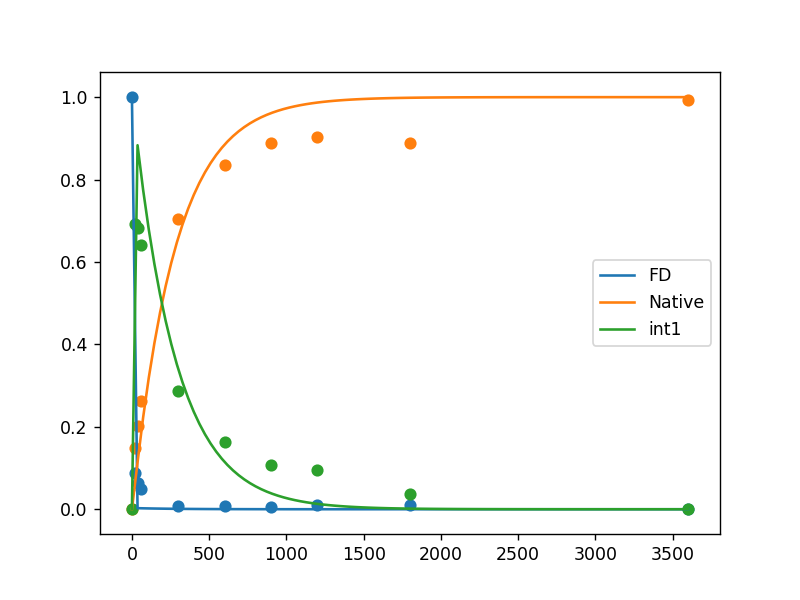

interactive(children=(FloatSlider(value=-3.0, description='k_int1FD', max=0.0, min=-3.0, step=0.03), FloatSlid…

In [53]:
# We can use fit.interactive for checking and adjusting initial guesses
fit.interactive()

In [54]:
{k: v.value for k, v in fit.parameters.items()}

{'k_int1FD': -3.0, 'k_FDint1': -0.46, 'k_int1Native': -2.44}

In [55]:
# We make the fit object, using the minimizer DifferentialEvolution. This minimzer searches all parameter 
# space for a global minimum. We then use SLSQP in a second step to refine the result. I've not tested all
# possibilities exhaustively so there might be better solutions
fit.make_fit(minimizer=[DifferentialEvolution, SLSQP])

In [56]:
fit.execute()

In [57]:
print(fit.res)

Scalar Parameters:
Parameter | Value       | Standard Deviation
k_FDint1    7.336594e-01  1.485439e-01
k_int1FD    -3.991032e-02  5.502668e-03
k_int1Native-2.356576e+00  6.635784e-02
Status message         Optimization terminated successfully.
Number of iterations   32
Objective              <symfit.core.objectives.LeastSquares object at 0x000001B5A188EC50>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x000001B5A188EC18>, <symfit.core.minimizers.SLSQP object at 0x000001B5A188EE48>])

Goodness of fit qualifiers:
chi_squared            0.0906897457843494
objective_value        0.0453448728921747
r_squared              0.9690272875692845


In [58]:
for k, v in fit.res.params.items():
    print(k, v, 10**v)

k_FDint1 0.7336594127071182 5.415760030069885
k_int1FD -0.03991031952809242 0.9121991862290437
k_int1Native -2.3565759095744356 0.004399710393448266


The found k value for conversion from `FD` to `int1` is $10^{0.95}$ which is equal to 8.97 $s^{-1}$. This is the largest value in the kinetic scheme which is as expected because the intermediate is formed very fast.

<IPython.core.display.Javascript object>


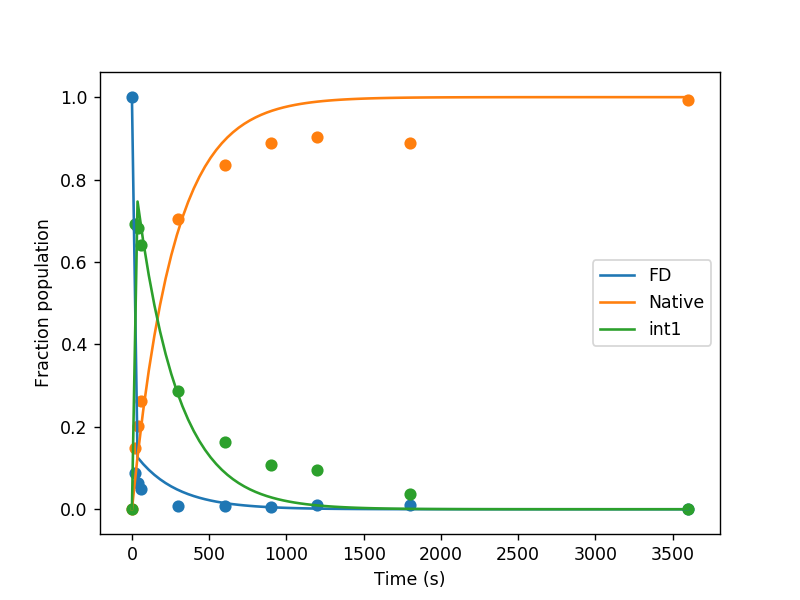

Text(0, 0.5, 'Fraction population')

In [59]:
fig, ax = fit.plot_result()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fraction population')